<a href="https://colab.research.google.com/github/VysePresident/Alzheimers_Disease_MRI_Classification/blob/main/PredOfAlzSeverityFirst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib as mpl
import numpy as np
from PIL import Image
import os

# Install Weights & Biases logging library
!pip install wandb -qU
%load_ext tensorboard

import matplotlib.pyplot as plt
import sklearn

print(tf.__version__)
print(np.version.version)
print(pd.__version__)



2.9.2
1.21.6
1.3.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import wandb
wandb.login()

In [ ]:
def load_individual_image(infilename):
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img, dtype="int32").flatten()
    return data

In [ ]:
def handleImages(nestedFileName):
  allImages = []
  for file in os.listdir(nestedFileName):
    allImages.append(load_individual_image(nestedFileName + file))
  return np.asarray(allImages)

In [ ]:
#from Allen's google drive
MildDemImageArr = handleImages("/content/drive/MyDrive/datasets/alzheimersmris/train/MildDemented/") / 255
ModDemImageArr = handleImages("/content/drive/MyDrive/datasets/alzheimersmris/train/ModerateDemented/") / 255
NonDemImageArr = handleImages("/content/drive/MyDrive/datasets/alzheimersmris/train/NonDemented/") / 255
VeryDemImageArr = handleImages("/content/drive/MyDrive/datasets/alzheimersmris/train/VeryMildDemented/") / 255


testarrone = handleImages("/content/drive/MyDrive/datasets/alzheimersmris/test/MildDemented/") / 255
testarrtwo = handleImages("/content/drive/MyDrive/datasets/alzheimersmris/test/ModerateDemented/") / 255
testarrthree = handleImages("/content/drive/MyDrive/datasets/alzheimersmris/test/NonDemented/") / 255
testarrfour = handleImages("/content/drive/MyDrive/datasets/alzheimersmris/test/VeryMildDemented/") / 255

In [ ]:
# Running from Isaac's drive:
MildDemImageArr = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/train/MildDemented/") / 255
ModDemImageArr = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/train/ModerateDemented/") / 255
NonDemImageArr = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/train/NonDemented/") / 255
VeryDemImageArr = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/train/VeryMildDemented/") / 255

testarrone = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/test/MildDemented/") / 255
testarrtwo = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/test/ModerateDemented/") / 255
testarrthree = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/test/NonDemented/") / 255
testarrfour = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/test/VeryMildDemented/") / 255

FileNotFoundError: ignored

In [ ]:
mildDX = np.concatenate((MildDemImageArr, testarrone), dtype=np.floating)
mildDY = np.ones(mildDX.shape[0])

modDX = np.concatenate((ModDemImageArr, testarrtwo), dtype=np.floating)
modDY = np.ones(modDX.shape[0])*2

noDX = np.concatenate((NonDemImageArr, testarrthree), dtype=np.floating)
noDY = np.ones(noDX.shape[0])*3

vDX = np.concatenate((VeryDemImageArr, testarrfour), dtype=np.floating)
vDY = np.ones(vDX.shape[0])*4

In [ ]:
Xtotal = np.concatenate((mildDX, modDX, noDX, vDX), dtype=np.floating)
Ytotal = np.concatenate((mildDY, modDY, noDY, vDY), dtype=np.floating)

In [ ]:
print(Xtotal.shape)
print(Ytotal.shape)
print(Xtotal[2400])
print(Ytotal[2400])

(6400, 36608)
(6400,)
[0. 0. 0. ... 0. 0. 0.]
3.0


# The Random Forest Model

In [ ]:
"""Random Forest Model"""
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xtotal, Ytotal, test_size=0.3)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

wandb.init(project="DTmodelsklearn")
# instantiate the DecisionTreeClassifier model with criterion gini index
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

# fit the model
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [ ]:
# predict the test set results with criterion gini index
y_pred_gini = clf_gini.predict(X_test)
y_probas_gini = clf_gini.predict_proba(X_test)

wandb.sklearn.plot_classifier(clf_gini, X_train, X_test, y_train, y_test, y_pred_gini, y_probas_gini, ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'],
                                                         model_name='DT', feature_names=None)

wandb: 
wandb: Plotting RF.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [ ]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:0.4f}'.format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.5682


In [ ]:
# Let's also compare the train-set and test-set accuracy and check for overfitting.
y_pred_train_gini = clf_gini.predict(X_train)
print('Training set score: {:.4f}'.format(clf_gini.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf_gini.score(X_test, y_test)))



Training set score: 0.5868
Test set score: 0.5682


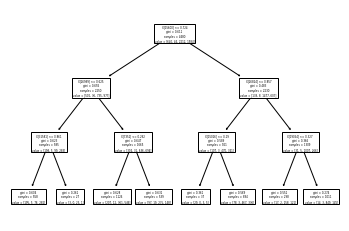

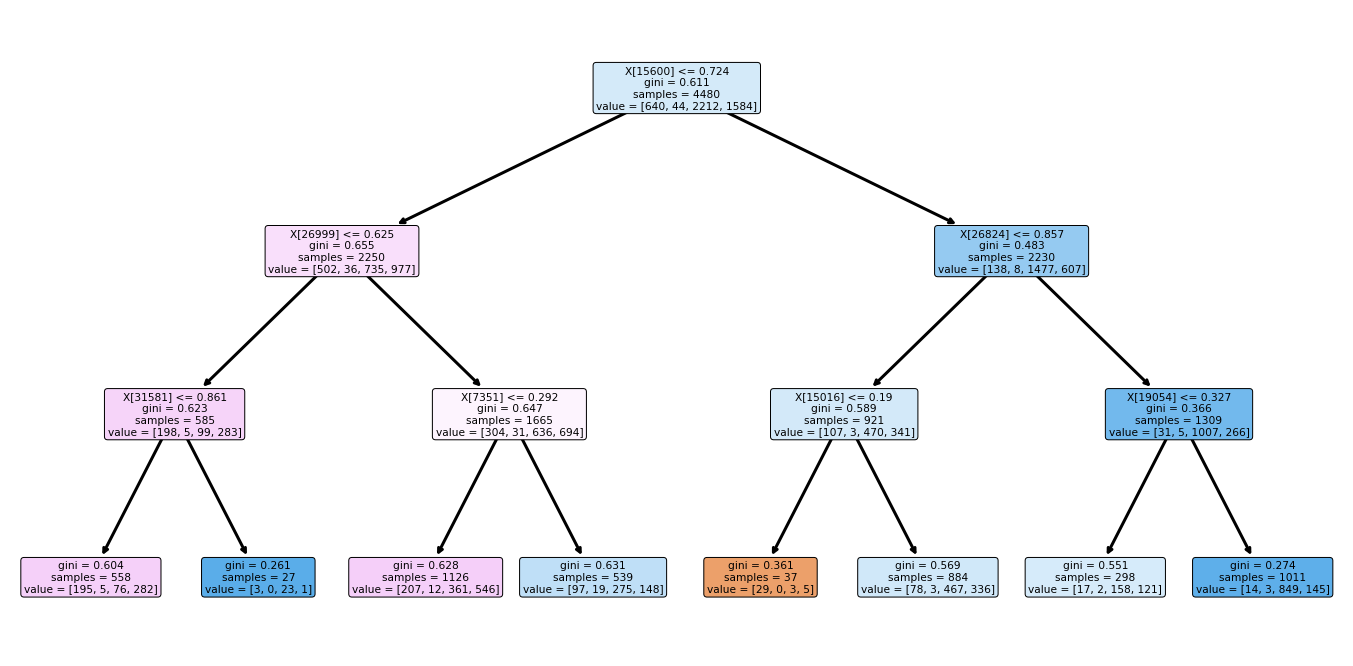

In [ ]:
from sklearn import tree
tree.plot_tree(clf_gini) 
plt.show()

categoricals = [1, 2, 3, 4]

fig, ax = plt.subplots(figsize=(24,12))
out = tree.plot_tree(clf_gini, filled=True, rounded=True)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=6, max_features='sqrt')
rfc.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
wandb.init(project="RFsklearn")

In [ ]:
y_pred = rfc.predict(X_test)
y_probas = rfc.predict_proba(X_test)

wandb.sklearn.plot_classifier(rfc, X_train, X_test, y_train, y_test, y_pred, y_probas, ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'],
                                                         model_name='RF', feature_names=None)

print('Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

wandb: 
wandb: Plotting RF.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


Model accuracy score: 0.9187


In [ ]:
# Confussion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Confusion Matrix for Random Forest:\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion Matrix for Random Forest:

 [[201   0  28  27]
 [  0   9   1  10]
 [  0   0 974  14]
 [  0   0  74 582]]

True Positives(TP) =  201

True Negatives(TN) =  9

False Positives(FP) =  0

False Negatives(FN) =  0


In [ ]:
from sklearn.metrics import classification_report

print("Classification Report for Random Forest:\n")
print(classification_report(y_test, rfc_pred))

Classification Report for Random Forest:

              precision    recall  f1-score   support

         1.0       1.00      0.78      0.88       286
         2.0       1.00      0.23      0.37        22
         3.0       0.87      0.98      0.93       931
         4.0       0.92      0.87      0.89       681

    accuracy                           0.90      1920
   macro avg       0.95      0.72      0.77      1920
weighted avg       0.91      0.90      0.90      1920



# SVM


SVM MODEL

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib as mpl
import numpy as np
from PIL import Image
import os


import matplotlib.pyplot as plt
import sklearn

print(tf.__version__)
print(np.version.version)
print(pd.__version__)

2.9.2
1.21.6
1.3.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def load_individual_image(infilename):
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img, dtype="int32").flatten()
    return data

In [ ]:
def handleImages(nestedFileName):
  allImages = []
  for file in os.listdir(nestedFileName):
    allImages.append(load_individual_image(nestedFileName + file))
  return np.asarray(allImages)

In [ ]:
MildDemImageArr = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/train/MildDemented/") / 255
ModDemImageArr = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/train/ModerateDemented/") / 255
NonDemImageArr = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/train/NonDemented/") / 255
VeryDemImageArr = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/train/VeryMildDemented/") / 255

testarrone = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/test/MildDemented/") / 255
testarrtwo = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/test/ModerateDemented/") / 255
testarrthree = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/test/NonDemented/") / 255
testarrfour = handleImages("/content/drive/MyDrive/Alzheimer_s Dataset/test/VeryMildDemented/") / 255

FileNotFoundError: ignored

In [ ]:
mildDX = np.concatenate((MildDemImageArr, testarrone), dtype=np.floating)
mildDY = np.ones(mildDX.shape[0])

modDX = np.concatenate((ModDemImageArr, testarrtwo), dtype=np.floating)
modDY = np.ones(modDX.shape[0])*2

noDX = np.concatenate((NonDemImageArr, testarrthree), dtype=np.floating)
noDY = np.ones(noDX.shape[0])*3

vDX = np.concatenate((VeryDemImageArr, testarrfour), dtype=np.floating)
vDY = np.ones(vDX.shape[0])*4

In [ ]:
Xtotal = np.concatenate((mildDX, modDX, noDX, vDX), dtype=np.floating)
Ytotal = np.concatenate((mildDY, modDY, noDY, vDY), dtype=np.floating)

In [ ]:
print(Xtotal.shape)
print(Ytotal.shape)
print(Xtotal[2400])
print(Ytotal[2400])

SVM Model

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
wandb.init(project="SVMsklearn")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xtotal, Ytotal, test_size=0.3)

In [ ]:
classifier = svm.SVC(C=10, gamma=0.001, probability=True, verbose=True, random_state=42)

In [ ]:
classifier.fit(X_train, y_train)

[LibSVM]

KeyboardInterrupt: ignored

In [ ]:
classifier_pred = classifier.predict(X_test)
classifier_proba = classifier.predict_proba(X_test)

NotFittedError: ignored

In [ ]:
from sklearn.metrics import accuracy_score

wandb.sklearn.plot_classifier(clf_gini, X_train, X_test, y_train, y_test, classifier_pred, classifier_proba, ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'],
                                                         model_name='SVM', feature_names=None)

print('Model accuracy score with criterion C=10, gamma=0.001, kernel="rbf"": {0:0.4f}'.format(accuracy_score(y_test, classifier_pred)))

In [ ]:
print("Classification report for classifier %s: \n%s\n"
     % (classifier, metrics.classification_report(y_test, classifier_pred)))
print("Confusion matrix: \n%s" % metrics.confusion_matrix(y_test, classifier_pred))

In [ ]:
# Compare training set data results to testing set data results:

classifier_pred_train = classifier.predict(X_train)
print('Training set score: {:.4f}'.format(classifier.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(classifier.score(X_test, y_test)))

In [ ]:
# Test batch training

In [ ]:
# Test other kernels

In [ ]:
rbf_classifier = svm.SVC(gamma=0.001)

In [ ]:
# TEST HYPERPARAMETER TRAINING

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

In [ ]:
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)

In [ ]:
grid.fit(X_train, y_train)

# CNN

In [ ]:
import tensorflow as tf
from tensorflow import keras 
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import cv2
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input

In [ ]:
train = ImageDataGenerator(rescale=1./255)
test =  ImageDataGenerator(rescale=1./255)
val =  ImageDataGenerator(rescale=1./255)

In [ ]:
#train="/content/Alzheimer_s Dataset/train"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train,
    validation_split=0.2,
    image_size=(224,224),
    batch_size=32,
    subset='training',
    seed=1000)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [ ]:
#val="/content/Alzheimer_s Dataset/train"

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
    )

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [ ]:
#test="/content/Alzheimer_s Dataset/test"

test_data=tf.keras.preprocessing.image_dataset_from_directory(
    test,
    image_size=(224,224),
    batch_size=32,
    seed=1000
    )

Found 1279 files belonging to 4 classes.


In [ ]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
train_data.class_names = class_names
val_data.class_names = class_names
print(val_data)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


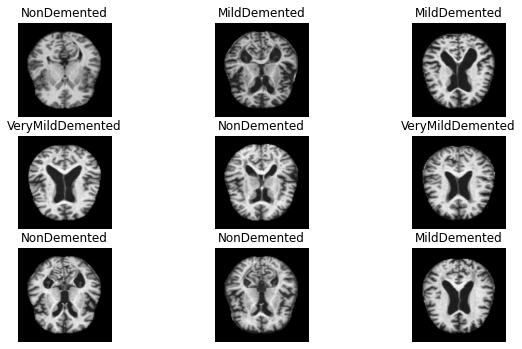

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[i]])
        plt.axis("off")
plt.savefig("sample.png")

In [ ]:
model=Sequential()

model.add(Conv2D(16,(3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(256,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Dense(4,activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(train_data, validation_data=val_data, epochs=50)


Epoch 1/100
114/129 [=========================>....] - ETA: 21s - loss: 1.8651 - accuracy: 0.3580

KeyboardInterrupt: ignored

In [ ]:
%tensorboard --logdir logs